# Análisis de Sentimientos de Coranavirus Tweets NLP - Text Classification
La base de datos utilizada en este proyecto ha sido extraída de Kaggle: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification. Los ficheros de datos están en formato CSV y están almacenados en los ficheros `Corona_NLP_test.csv` y `Corona_NLP_train.csv`. Estos ficheros contienen tweets relacionados con el coronavirus, junto con su respectiva etiqueta de sentimiento (positivo, negativo o neutro).

El objetivo de este proyecto es clasificar los tweets en las diferentes categorías. Para ello, se utilizará un modelo de clasificación de texto basado en técnicas de procesamiento de lenguaje natural (NLP).
En primer lugar, importamos las librerías necesarias:

In [3]:
from sentence_transformers import SentenceTransformer, InputExample
import torch.nn as nn
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
from src.models import Transformer_Classifier, Classifier
from sklearn.preprocessing import LabelEncoder

## Preprocesamiento de datos
A continuación, cargamos la base de datos con pandas y visualizamos su información. La base de datos contiene 2 columnas: "text" (el tweet), "sentiment" (la etiqueta de sentimiento). La columna "sentiment" contiene las etiquetas que queremos predecir. 


In [ ]:
df_train = pd.read_csv('sentiment_data/Corona_NLP_train.csv', encoding='latin-1')
df_test = pd.read_csv('sentiment_data/Corona_NLP_test.csv', encoding='latin-1')

df_train = df_train[['OriginalTweet', 'Sentiment']]
df_test = df_test[['OriginalTweet', 'Sentiment']]
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  3798 non-null   object
 1   Sentiment      3798 non-null   object
dtypes: object(2)
memory usage: 59.5+ KB
None


Analizamos la distribución de las etiquetas de sentimiento en la base de datos. Para ello, utilizamos la función value_counts() de pandas para contar el número de tweets en cada categoría.

In [35]:
print("Contando valores de sentiment en train:")
print(df_train['Sentiment'].value_counts())

print("Contando valores de sentiment en test:")
print(df_test['Sentiment'].value_counts())


Contando valores de sentiment en train:
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64
Contando valores de sentiment en test:
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64


Vamos a hacer un mapeo de "Extremely Positive" a "Positive" y de "Extremely Negative" a "Negative", ya que queremos simplificar el problema a tres categorías: "Positive", "Negative" y "Neutral". Para ello, utilizamos la función replace() de pandas para reemplazar los valores en la columna "sentiment". A continuación, visualizamos la distribución de las etiquetas de sentimiento en la base de datos después del mapeo con ayuda de un gráfico de barras.

In [36]:
mapping = {
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative',
    'Positive': 'Positive',
    'Negative': 'Negative',
    'Neutral': 'Neutral'
}

df_train['Sentiment'] = df_train['Sentiment'].map(mapping)
df_test['Sentiment'] = df_test['Sentiment'].map(mapping)

<Axes: >

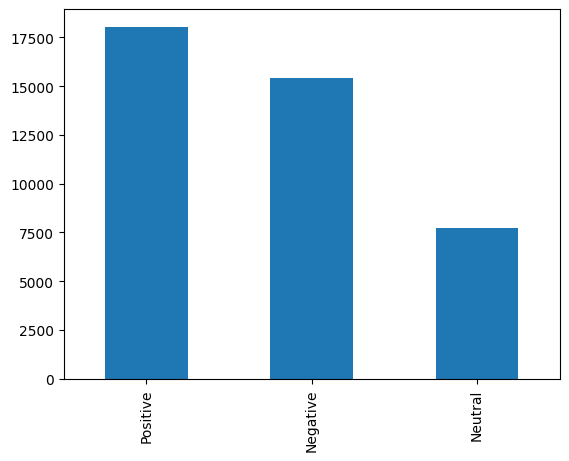

In [37]:
df_train['Sentiment'].value_counts().plot(kind='bar')

## Entrenamiento y validación
Es momento de definir el modelo sobre el que se hará fine-tuning: `paraphrase-MiniLM-L6-v2`. Este modelo es un modelo de lenguaje preentrenado que ha sido ajustado para tareas de clasificación de texto. Utilizaremos la librería `transformers` de Hugging Face para cargar el modelo y la tokenización. A continuación, definimos la función `encode_data()` para tokenizar los tweets y convertirlos en tensores.

Por otra parte, instanciamos el clasificador de texto `Transformer Classifier` sobre el que haremos fine-tuning. Este clasificador concatena la salida del `SentenceTransformer` con una capa lineal.

In [39]:
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['Sentiment'])
df_test['label'] = label_encoder.transform(df_test['Sentiment'])

sent_transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')
classifier = Classifier(
    sent_transformer.get_sentence_embedding_dimension(), 3
)
tuned_transformer = Transformer_Classifier(
    sent_transformer, classifier
)

Realizamos el fine-tuning del modelo.

In [40]:
train_input_ex = [InputExample(texts=[tc], label=l) for tc, l in zip(df_train["OriginalTweet"], df_train["label"])]

def collate_fn(batch):
    texts = [x.texts[0] for x in batch]
    labels = torch.tensor([x.label for x in batch])
    return texts, labels

train_ratio = 0.8
train_size = int(len(train_input_ex) * train_ratio)
val_size = len(train_input_ex) - train_size

train_dataset, val_dataset = random_split(train_input_ex, [train_size, val_size])

batch_size = 2
train_dataLoader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
val_dataLoader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Para el entrenamiento:
learning_rate = 2e-5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tuned_transformer.parameters(), lr=learning_rate)


# Número máximo de épocas
max_epochs = 15
total_steps = len(train_dataLoader) * max_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# Entrenamiento con validación
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
tuned_transformer = tuned_transformer.to(device) 
best_val_accuracy = 0.0
# Implementamos Early Stopping
early_stopping_patience = 3
epochs_without_improvement = 0
loss_list = []

for epoch in range(max_epochs):
    tuned_transformer.train()
    running_loss = 0.0
    
    for step, (texts, labels) in enumerate(train_dataLoader):
        labels = labels.to(device)
        optimizer.zero_grad()
        # Tokenizamos los textos con el modelo de SentenceTransformer
        input_tokens = sent_transformer.tokenize(texts)
        inputs_ids = input_tokens['input_ids'].to(device)
        attention_mask = input_tokens['attention_mask'].to(device)
        inputs_final = {
            'input_ids': inputs_ids,
            'attention_mask': attention_mask
        }
        logits = tuned_transformer(inputs_final)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        act_loss = loss.item()
        running_loss += act_loss
        
        if step % 101 == 0:
            print(f"Epoch: {epoch+1}/{max_epochs}, Step: {step}/{len(train_dataLoader)}, Loss: {act_loss:4f}, Avg Loss: {running_loss/(step+1):.3f}")
        
    epoch_loss = running_loss / len(train_dataLoader)
    print(f"Epoch {epoch+1}/{max_epochs}, Training Loss: {epoch_loss:.4f}")
    loss_list.append(epoch_loss)
    
    # Validación
    tuned_transformer.eval()
    val_pred = []
    val_labels_list = []
    
    with torch.no_grad():
        for texts, labels in val_dataLoader:
            labels = labels.to(device)
            inputs = sent_transformer.tokenize(texts)
            inputs_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            inputs_final = {
                'input_ids': inputs_ids,
                'attention_mask': attention_mask
            }
            logits = tuned_transformer(inputs_final)
            
            # Extraemos las predicciones
            predictions = torch.argmax(logits, dim=1)
            val_pred.extend(predictions.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())
    
    # Calculamos la precisión de validación
    val_accuracy = accuracy_score(val_labels_list, val_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # early sttopping:
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_without_improvement = 0
        print(f"New best model found with accuracy: {best_val_accuracy:.4f}. Saving model...")
        sent_transformer.save(f"best_models/sentiment/epoch_{epoch+1}")
        best_epoch = epoch + 1
        print("Model saved.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement in validation accuracy for {epochs_without_improvement} epochs.")
        
    if epochs_without_improvement >= early_stopping_patience:
        print("Early stopping triggered.")
        break

print(f"Training completed. Best validation accuracy: {best_val_accuracy:.4f}.")



Using device: cpu
Epoch: 1/15, Step: 0/16463, Loss: 0.957538, Avg Loss: 0.958
Epoch: 1/15, Step: 101/16463, Loss: 0.901247, Avg Loss: 1.040
Epoch: 1/15, Step: 202/16463, Loss: 0.553357, Avg Loss: 0.975
Epoch: 1/15, Step: 303/16463, Loss: 0.750833, Avg Loss: 0.913
Epoch: 1/15, Step: 404/16463, Loss: 1.089126, Avg Loss: 0.845
Epoch: 1/15, Step: 505/16463, Loss: 0.464621, Avg Loss: 0.800
Epoch: 1/15, Step: 606/16463, Loss: 0.394423, Avg Loss: 0.786
Epoch: 1/15, Step: 707/16463, Loss: 0.607678, Avg Loss: 0.760
Epoch: 1/15, Step: 808/16463, Loss: 1.928690, Avg Loss: 0.748
Epoch: 1/15, Step: 909/16463, Loss: 0.125313, Avg Loss: 0.738
Epoch: 1/15, Step: 1010/16463, Loss: 0.828807, Avg Loss: 0.733
Epoch: 1/15, Step: 1111/16463, Loss: 0.820307, Avg Loss: 0.728
Epoch: 1/15, Step: 1212/16463, Loss: 0.116661, Avg Loss: 0.722
Epoch: 1/15, Step: 1313/16463, Loss: 0.501669, Avg Loss: 0.709
Epoch: 1/15, Step: 1414/16463, Loss: 1.430885, Avg Loss: 0.700
Epoch: 1/15, Step: 1515/16463, Loss: 0.555222, Av

Esta salida de resultados la almacenamos un un fichero txt para poder parsearla y obtener los datos.

In [4]:
import re
def parse_training_log(file_path):
    # Patrones para extraer datos
    train_pattern = re.compile(r"Epoch (\d+)/\d+, Training Loss: (\d+\.\d+)")
    val_pattern = re.compile(r"Validation Accuracy: (\d+\.\d{4})")
    
    data = []
    current_epoch = None
    
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            
            # Buscar línea de entrenamiento
            train_match = train_pattern.search(line)
            if train_match:
                current_epoch = int(train_match.group(1))
                train_loss = float(train_match.group(2))
                data.append({"Epoch": current_epoch, "Training Loss": train_loss})
            
            # Buscar línea de validación (solo si ya encontramos una época)
            val_match = val_pattern.search(line)
            if val_match and current_epoch is not None:
                val_accuracy = float(val_match.group(1))
                # Actualizar la entrada correspondiente
                for entry in data:
                    if entry["Epoch"] == current_epoch:
                        entry["Validation Accuracy"] = val_accuracy
                        break
    
    return pd.DataFrame(data)

In [ ]:
df = parse_training_log("sentiment_results/results_training.txt")

# Guardar en CSV
df.to_csv("training_results.csv", index=False)

Datos guardados en training_results.csv


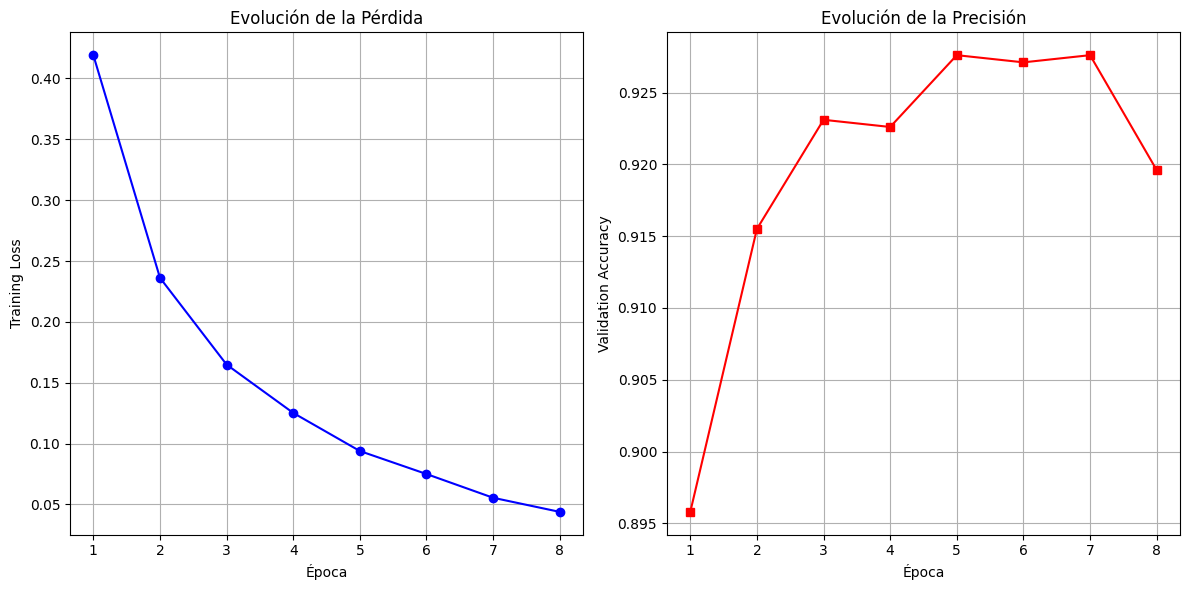

In [5]:
import matplotlib.pyplot as plt
print("Datos guardados en training_results.csv")

df = pd.read_csv("sentiment_results/training_results.csv")
# Crear gráficas
plt.figure(figsize=(12, 6))

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(df["Epoch"], df["Training Loss"], "b-o")
plt.title("Evolución de la Pérdida")
plt.xlabel("Época")
plt.ylabel("Training Loss")
plt.grid(True)

# Gráfica de precisión
plt.subplot(1, 2, 2)
plt.plot(df["Epoch"], df["Validation Accuracy"], "r-s")
plt.title("Evolución de la Precisión")
plt.xlabel("Época")
plt.ylabel("Validation Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


Observamos en la gráfica cómo la estrategia early stopping ha funcionado correctamente, ya que la pérdida de validación no ha mejorado durante 3 épocas. Esto indica que el modelo ha alcanzado su mejor rendimiento en la época 5 y no se beneficiará de más entrenamiento.

## Inferencia sobre el conjunto de test
Usamos un árbol xgboost para hacer la inferencia sobre el conjunto de test, metiéndole como entradas las salidas del modelo de clasificación de texto sobre el que se ha hecho fine-tuning y el modelo original. El objetivo es contrastar la diferencia de resultados entre ambos modelos.

### Modelo original


In [41]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df_train["OriginalTweet_emb"] = df_train["OriginalTweet"].apply(
    lambda x: model.encode(x)
)
df_test["OriginalTweet_emb"] = df_test["OriginalTweet"].apply(
    lambda x: model.encode(x)
)

X_train = pd.DataFrame(
    df_train["OriginalTweet_emb"].to_list(),
    index=df_train.index,
    dtype=float,
)
X_test = pd.DataFrame(
    df_test["OriginalTweet_emb"].to_list(),
    index=df_test.index,
    dtype=float,
)
y_train = df_train["label"]
y_test = df_test["label"]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'multi:softmax',
    'num_class': len(df_train['label'].unique()),
    'eval_metric': 'mlogloss'
}

training_rounds = 100
bst=xgb.train(param, dtrain, training_rounds)
preds = bst.predict(dtest)
accuracy_initial_model = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy_initial_model:.4f}")


Accuracy: 0.6445


### Modelo fine-tuned

In [42]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

model = SentenceTransformer(f"best_models/sentiment/epoch_{best_epoch}")

df_train["OriginalTweet_tuned"] = df_train["OriginalTweet"].apply(
    lambda x: model.encode(x)
)
df_test["OriginalTweet_tuned"] = df_test["OriginalTweet"].apply(
    lambda x: model.encode(x)
)

X_train = pd.DataFrame(
    df_train["OriginalTweet_tuned"].to_list(),
    index=df_train.index,
    dtype=float,
)
X_test = pd.DataFrame(
    df_test["OriginalTweet_tuned"].to_list(),
    index=df_test.index,
    dtype=float,
)
y_train = df_train["label"]
y_test = df_test["label"]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'multi:softmax',
    'num_class': len(df_train['label'].unique()),
    'eval_metric': 'mlogloss'
}

training_rounds = 100
bst=xgb.train(param, dtrain, training_rounds)
preds = bst.predict(dtest)
accuracy_initial_model = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy_initial_model:.4f}")


Accuracy: 0.9150


Se ha demostrado la eficacia del modelo fine-tuned, ya que ha superado en un 27% al modelo original. Esto indica que el fine-tuning ha mejorado significativamente el rendimiento del modelo en la tarea de clasificación de sentimientos en tweets relacionados con el COVID-19.